# Predict the predicted improvement due to thrombolysis 
For the patients in the training set calculate the SHAP improvement due to IVT - will use this as the target feature for the XGBoost model.

### Plain English summary

Use XGBoost model to obtaint he SHAP value for the IVT feature, for a patient having IVT and not. Calculate the improvement contributed by IVT to the patients disability ay discharge, what we will refer to as the "predicted improvemnt due to thrombolysis".

Fit an XGBoost model to predict the predicted improvement due to thrombolysis, using 7 features: "prior_disability", "stroke_severity", "stroke_team", "age", "onset_to_thrombolysis_time", "any_afib_diagnosis", "precise_onset_known".


### Model and data
Train an XGBoost model to predict the predicted improvement due to thrombolysis

Use the same 7 input features as in the disability outcome model (as it's only those features that created the target feature): 1) prior_disability, 2) stroke_severity, 3) stroke_team, 4) age, 5) onset-to-thrombolysis-time, 6) any_afib_diagnosis 7) precise_onset_known

Use just the first kfold split.


### Aims


### Observations




#### Further work

#### Resources
Using code from https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/02b_xgb_combined_fit_accuracy_key_features_separate_k_fold.ipynb

and https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/03_xgb_combined_shap_key_features.ipynb

## Import libraries

In [68]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from dataclasses import dataclass

from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix

import pickle
import shap

from os.path import exists

import time
import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression


Report the time duration to run notebook

In [69]:
start_time = time.time()

Use just the first k-fold split, and define the target feature

In [70]:
k = 0
target_feature = 'discharge_disability'

Select the features for the model

In [71]:
selected_features = ["prior_disability", "stroke_severity", "stroke_team", 
                     "age", "onset_to_thrombolysis_time", "any_afib_diagnosis", 
                     "precise_onset_known"]
n_features = len(selected_features)
selected_features.append(target_feature)

## Set up paths and filenames

Use os.path.join() to create filenames. So define folders without trailing forward slash, and include all characters in file names.

In [72]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    model_save_path: str = './saved_models'
    data_save_path: str = './saved_data'
    data_read_path: str = '../data_processing/output/kfold_5fold'
    model_text: str = f'xgb_{n_features}_features_1_kfold_ivt_improvement'
    notebook: str = '110_'

paths = Paths()

Create output folders if needed

In [73]:
path = paths.image_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

path = paths.data_save_path
if not os.path.exists(path):
    os.makedirs(path)

## Import data

Import the first kfold split

In [74]:
# Read in training set, restrict to chosen features, & store
filename = os.path.join(paths.data_read_path, '03_train_0.csv')
train = pd.read_csv(filename)
train = train[selected_features]

filename = os.path.join(paths.data_read_path, '03_test_0.csv')
test = pd.read_csv(filename)
test = test[selected_features]

Store the output classes

In [75]:
class_names = train['discharge_disability'].unique()
class_names = np.sort(class_names)
n_classes = len(class_names)

### One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [76]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    Converts a categorical feature into a one hot encoded feature
    
    Args:
        df [dataframe]: training or test dataset
        feature_name [str]: feature to convert to one hot encoding
        prefix [str]: string to use on new feature

    Return:
        df [dataframe]: One hot encoded representation of the feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [77]:
features_to_one_hot = ["stroke_team", "weekday"]
list_prefix = ["team", "weekday"]

For each feature in the list, for each train and test dataset, convert to one hot encoded.

In [78]:
for feature, prefix in zip(features_to_one_hot, list_prefix):
    if feature in selected_features:
        train = convert_feature_to_one_hot(train, feature, prefix)
        test = convert_feature_to_one_hot(test, feature, prefix)

Feature names with one hot encoding

In [79]:
features_ohe = list(train)
features_ohe.remove("discharge_disability")
n_features_ohe = len(features_ohe)

print(f"There are {n_features} original features (before one-hot encoding)")
print(f"There are {n_features_ohe} features (after one-hot encoding)")

There are 7 original features (before one-hot encoding)
There are 124 features (after one-hot encoding)


Read in the data that contains the improvement due to IVT use (created in notebook 100)

In [ ]:
filename = os.path.join(paths.data_save_path,
                        (f"100_xgb_{n_features}_features_1_kfold_binary" + 
                        "_improvement_due_to_ivt.csv"))

df_test_ivt_and_no_ivt_shap = pd.read_csv(filename)

Create function to return X and y data for train and test sets

In [80]:
def get_x_y_data(train, test, target):
    """
    Pass data from the split and return the dataframes with the target in one 
    dataframe (X), and dependent features in another (y)
    
    train (dataframe): dataframe containing training instances 
    test (dataframe): dataframe containing test instances
    target (string): column name of the targert feature (the column to separate from the two dataframes)
    """    

    # Get X and y
    X_train = train.drop(target, axis=1)
    X_test = test.drop(target, axis=1)
    y_train = train[target]
    y_test = test[target]

    return(X_train, X_test, y_train, y_test)

Keep original y_test and y_train, then overwrite them for each binary model (using a different threshold)

In [81]:
(X_train, X_test, y_train_orig, y_test_orig) = get_x_y_data(train, test,
                                                         'discharge_disability')

## Load XGBoost model

In [83]:
def fit_xgboost(filename, X_train, y_train):

        # Check if exists
    file_exists = exists(filename)

    if file_exists:
    # Load models
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
    else:
        print ("Run notebook 100 (that notebook trains and saves the model)")
    return(model)

In [84]:
def calc_shap_values(shap_filename, explainer_filename, model, X_data, 
                     X_background):
    
    # Check if exists
    file_exists = exists(shap_filename)

    if file_exists:
        # Load explainer
        with open(shap_filename, 'rb') as filehandler:
            shap_values_extended = pickle.load(filehandler)
    else:
        # Calculate SHAP values

        # Set up explainer using the model and feature values from training set
        explainer = shap.TreeExplainer(model, X_background)

        # Get (and store) Shapley values along with base and feature values
        shap_values_extended = explainer(X_data)

        # Save explainer using pickle
        with open(explainer_filename, 'wb') as filehandler:
            pickle.dump(explainer, filehandler)
            
        # Save shap values extendedr using pickle
        with open(explainer_filename, 'wb') as filehandler:
            pickle.dump(shap_values_extended, filehandler)
            
    return(shap_values_extended)

In [85]:
r_square_threshold = []
roc_auc_ovr_threshold = []
accuracy_threshold = []
error_within_one_threshold = []
feature_importance_threshold = []
y_probs_threshold = []
y_pred_threshold = []
model_threshold = []
shap_values_test_extended_threshold = []
shap_values_train_extended_threshold = []
shap_values_test_threshold = []
shap_values_train_threshold = []

# Loop through thresholds folds
for t in range(6):
    binary_target_feature = f'binary_{t}'
    y_train = convert_feature_to_binary(y_train_orig, t)
    y_test = convert_feature_to_binary(y_test_orig, t)

    # Model filename
    filename = os.path.join(paths.model_save_path, 
                            (paths.notebook + paths.model_text + '_' +
                             str(t) + '.p'))

    model = fit_xgboost(filename, X_train, y_train)

    model_threshold.append(model)

    # Get target categories from model
    classes = model.classes_

    # Get and store predicted probabilities
    y_probs = model.predict_proba(X_test)
    y_probs_threshold.append(y_probs)#[:,1])

    # Get and store predicted class
    y_pred = model.predict(X_test)
    y_pred_threshold.append(y_pred)

    # Calculate ROC AUC for multiclass models, using One vs Rest
    roc_auc_ovr = roc_auc_score(y_test, y_probs[:,1], labels = classes, 
                                multi_class = 'ovr', average = 'macro')
    roc_auc_ovr_threshold.append(roc_auc_ovr)

    # Calculate error
    y_error = y_test - y_pred
    accuracy = np.mean(y_error==0)
    accuracy_threshold.append(accuracy)

    error_within_one = np.mean(np.abs(y_error)<=1)
    error_within_one_threshold.append(error_within_one)

    # Get and store feature importances
    feature_importance = model.feature_importances_
    feature_importance_threshold.append(feature_importance)

    # Calculate SHAP for test dataset
    shap_test_filename = os.path.join(paths.data_save_path, 
                                      (paths.notebook + paths.model_text +
                                       '_' + str(t) + 
                                       '_shap_values_test_extended.p'))

    explainer_filename = os.path.join(paths.data_save_path, 
                                      (paths.notebook + paths.model_text +
                                       '_' + str(t) + '_shap_explainer.p'))

    (shap_values_test_extended) = calc_shap_values(shap_test_filename, 
                                    explainer_filename, model, X_test, X_train)
    
    # Append shap values extended to list
    shap_values_test_extended_threshold.append(shap_values_test_extended)

    # Calculate SHAP for train dataset
    shap_train_filename = os.path.join(paths.data_save_path, 
                                      (paths.notebook + paths.model_text +
                                       '_' + str(t) + 
                                       '_shap_values_train_extended.p'))
    
    (shap_values_train_extended) = calc_shap_values(shap_train_filename, 
                                    explainer_filename, model, X_train, X_train)
    
    # Append shap values to list
    shap_values_train_extended_threshold.append(shap_values_train_extended)

 82%|================    | 27655/33670 [00:17<00:03]         

 87%|=================   | 29337/33670 [00:18<00:02]       

Create the dataframe of values

Take patients from test set that receive thrombolysis. Create a dataframe that has these patients repeated 6 times (one for each mRS threshold), and store their SHAP value and feature value for the feature "onset_to_thromboylsis_time".

Fit a linear regression to the SHAP vs feature value.

In [ ]:
# Find the column index for the feature "onset_to_thrombolysis_time
ivt_loc = X_test.columns.tolist().index("onset_to_thrombolysis_time")

In [ ]:
def create_df(X_data, shap_values_test_extended_threshold, mask, ivt_loc):
    """ 
    
    """
    # initiate a Dataframe with the required columns 
    columns=["patient_id", "mRS_threshold", "shap_ivt", 
             "onset_to_thrombolysis_time"]
    df = pd.DataFrame(columns=columns)

    # Go through each mRS threshold and create a temporary dataframe, then 
    # append it (add rows) to the main dataframe.
    for t in range(6):
        # Initiate dataframe        
        df_temp = pd.DataFrame(data=mask.index[mask], 
                            columns=["patient_id"])
        
        # Store the mRS threshold
        df_temp[f"mRS_threshold"] = t

        # Extract SHAP values for this threshold
        shap_values = shap_values_test_extended_threshold[t].values

        # Store the SHAP values for this threshold, for feature onset_to_thrombolysis_time
        df_temp["shap_ivt"] = (shap_values[mask, ivt_loc])
        
        # Store the feature values for feature onset_to_thrombolysis_time
        df_temp["onset_to_thrombolysis_time"] = (
                    X_data["onset_to_thrombolysis_time"][mask].values)

        # Append rows to the main dataframe
        df = df.append(df_temp)

    return(df)

In [ ]:
# mask the patients in test set that recieve IVT
mask_get_ivt = X_test["onset_to_thrombolysis_time"] > -100

# create dataframe of the SHAP values for feature onset_to_thrombolysis for 
# patients that receive IVT (for each threshold model)
df_test_ivt_shap = create_df(X_test, shap_values_test_extended_threshold, 
                             mask_get_ivt, ivt_loc)

In [ ]:
df_test_ivt_shap

,patient_id,mRS_threshold,shap_ivt,onset_to_thrombolysis_time
0,6,0,0.575995,90.0
1,7,0,0.453751,183.0
2,12,0,0.557330,187.0
3,15,0,0.066782,232.0
4,16,0,0.353205,165.0
...,...,...,...,...
6892,33652,5,0.539300,132.0
6893,33656,5,-0.221347,118.0
6894,33657,5,-0.002620,180.0
6895,33666,5,0.169626,124.0


Want to fit to the improvement due to thrombolysis.

To do this, calculate the SHAP value for feature Onset to thrombolysis time, by setting those patients that have thrombolysis as not having it, and getting new SHAP predictions but with all other features the same. We could then subtract that SHAP from the patients SHAP as having thrombolysis. So do it for each patient separately.

For each patient calculate the improvement due to thrombolysis by subtracting their SHAP value as if not have thrtombolysis (wrt threshold).

Recalculate the linear regression (per threshold), fitting to the SHAP value minus the average SHAP value for those patients without thrombolysis

In [ ]:
# Take deep copy of X_test, setting all patients as not having treatment
X_test_not_get_ivt = X_test.copy(deep=True)
X_test_not_get_ivt["onset_to_thrombolysis_time"] = -100

# Initialise empty list
shap_values_test_extended_no_ivt_threshold = []

# Loop through thresholds.
for t in range(6):  

    # Get model
    model = model_threshold[t]

    # set up filename for shap explainer
    explainer_filename = os.path.join(paths.model_save_path, 
                                        (paths.notebook + paths.model_text +
                                        '_' + str(t) + '_shap_explainer.p'))

    # set up filename for shap values for patients as if none got IVT
    shap_values_test_extended_no_ivt_filename = os.path.join(
                                        paths.data_save_path, 
                                        (paths.notebook + paths.model_text +
                                        '_' + str(t) + 
                                        '_shap_values_test_extended_no_ivt.p'))


    # Get (and store) Shapley values along with base and feature values
    shap_values_test_extended_no_ivt = calc_shap_values(
                                    shap_values_test_extended_no_ivt_filename, 
                                    explainer_filename, model, 
                                    X_test_not_get_ivt, X_train)
    

    shap_values_test_extended_no_ivt_threshold.append(
                                    shap_values_test_extended_no_ivt)



 99%|===================| 33445/33670 [00:22<00:00]        

In [ ]:
# Loop through thresholds. Get model and calc SHAP for patients not getting IVT
for t in range(6):  
    model = model_threshold[t]
    
    # Set up explainer using the model and feature values from training set
    explainer = shap.TreeExplainer(model, X_train)

    # Get (and store) Shapley values along with base and feature values
    shap_values_test_extended_no_ivt = explainer(X_test_not_get_ivt)
    shap_values_test_extended_no_ivt_threshold.append(shap_values_test_extended_no_ivt)

100%|===================| 33646/33670 [00:23<00:00]        

In [ ]:
def create_df_with_without_ivt(X_data, shap_values_extended_ivt_threshold, 
                               shap_values_extended_no_ivt_threshold):
    # initiate a Dataframe with the required columns 
    columns=(["patient_id","stroke_severity", "mRS_threshold", "shap_ivt", 
              "shap_not_ivt", "shap_ivt_improvement",
              "onset_to_thrombolysis_time"])
    df = pd.DataFrame(columns=columns)
                
    # Create mask for patients that recieve thrombolysis
    mask_get_ivt = X_data["onset_to_thrombolysis_time"]>-100

    # Go through each mRS threshold and create a dataframe, then append it (add rows) to the main dataframe.
    for t in range(6):
        df_temp=pd.DataFrame(data=mask_get_ivt.index[mask_get_ivt], 
                            columns=["patient_id"])
        # Store the mRS threshold
        df_temp[f"mRS_threshold"] = t
        # Get SHAP values for this threshold
        sv = shap_values_extended_ivt_threshold[t].values
        sv_not = shap_values_extended_no_ivt_threshold[t].values

        # Store the SHAP values for feature onset_to_thrombolysis_time
        df_temp["shap_ivt"] = sv[mask_get_ivt, ivt_loc]
        df_temp["shap_not_ivt"] = sv_not[mask_get_ivt, ivt_loc]
        # Store the feature values for feature onset_to_thrombolysis_time
        df_temp["onset_to_thrombolysis_time"] = (
                X_data["onset_to_thrombolysis_time"][mask_get_ivt].values)
        df_temp["stroke_severity"] = (
                X_data["stroke_severity"][mask_get_ivt].values)

        # Append rows to the main dataframe
        df = df.append(df_temp)

    df["shap_ivt_improvement"] = (df["shap_ivt"] - df["shap_not_ivt"])
    
    return(df)

In [ ]:
df_test_ivt_and_no_ivt_shap = create_df_with_without_ivt(X_test, 
                shap_values_test_extended_threshold, 
                shap_values_test_extended_no_ivt_threshold)
df_test_ivt_and_no_ivt_shap

,patient_id,stroke_severity,mRS_threshold,shap_ivt,shap_not_ivt,shap_ivt_improvement,onset_to_thrombolysis_time
0,6,5,0,0.575995,-0.091185,0.667180,90.0
1,7,9,0,0.453751,-0.048855,0.502605,183.0
2,12,10,0,0.557330,-0.095585,0.652915,187.0
3,15,5,0,0.066782,-0.093205,0.159988,232.0
4,16,8,0,0.353205,-0.091710,0.444915,165.0
...,...,...,...,...,...,...,...
6892,33652,24,5,0.539300,-0.124525,0.663825,132.0
6893,33656,2,5,-0.221347,-0.010170,-0.211177,118.0
6894,33657,10,5,-0.002620,-0.115940,0.113321,180.0
6895,33666,12,5,0.169626,-0.015969,0.185595,124.0


Plot the test set results

In [ ]:
def create_mosaic_plot(df_test_ivt_and_no_ivt_shap, max_treatment_time, 
                           filename_suffix):
    """ 
    
    
    """
    fig, ax = plt.subplot_mosaic(
        [
        ['main', 'mRS0', 'mRS1', 'mRS2'],
        ['main', 'mRS3', 'mRS4', 'mRS5'],
        ],
        width_ratios=[2, 1, 1, 1],
        layout='constrained',
        figsize=(15,6),
    )
    plt.rcParams['legend.title_fontsize'] = 'x-small'

    fig.suptitle(f"Estimated improvement in discharge disability that's "
                 f"associated with thrombolysis treatment\n(data limited to "
                 f"patients who received thrombolysis within "
                 f"{max_treatment_time} minutes of stroke onset, to fit the "
                 f"linear regressions)")

    handles = []

    point_color = ["red", "orange", "yellow", "green", "blue", "mediumorchid"]
    line_color = ["firebrick", "darkorange", "gold", "darkgreen", "mediumblue", 
                  "darkorchid"]
#    text = "With 0 minutes onset to thrombolysis time:"
    label = ["mRS0","mRS1","mRS2","mRS3","mRS4","mRS5"]

    max_zero_effect = 0
    for t in range(6):

        mask = df_test_ivt_and_no_ivt_shap["mRS_threshold"] == t

        # Generate data
        x = df_test_ivt_and_no_ivt_shap["onset_to_thrombolysis_time"][mask]
        y = df_test_ivt_and_no_ivt_shap["shap_ivt_improvement"][mask]

        # Add scatterplot
        ax['main'].scatter(x, y, s=1, color = 'grey', alpha=0.1)
        ax[f'mRS{t}'].scatter(x, y, s=1, alpha=0.3, color=point_color[t],
                              label=label[t])
    
        # Fit linear regression via least squares with numpy.polyfit
        # It returns an slope (b) and intercept (a)
        # deg=1 means linear fit (i.e. polynomial of degree 1)
        b, a = np.polyfit(x, y, deg=1)
        # Want to set xlim max to include all of the zero effects (where SHAP = 0)
        zero_effect = -a/b
        max_zero_effect = max(max_zero_effect, zero_effect)

    # Fit linear regression via least squares with numpy.polyfit
    # It returns an slope (b) and intercept (a)
    # deg=1 means linear fit (i.e. polynomial of degree 1)
    x = df_test_ivt_and_no_ivt_shap["onset_to_thrombolysis_time"]
    y = df_test_ivt_and_no_ivt_shap["shap_ivt_improvement"]
    b, a = np.polyfit(x, y, deg=1)

    # Want to set xlim max to include all of the zero effects (where SHAP = 0)
    zero_effect = -a/b
    max_zero_effect = max(max_zero_effect, zero_effect)

    # Create sequence of 100 numbers from 0 to max zero limit
    xseq = np.linspace(0, max_zero_effect, num=100)

    # Plot regression line
    l, = ax['main'].plot(xseq, a + b * xseq, color="dimgray", lw=2.5, 
                         label="All mRS thresholds");

    ax['main'].set_title(f"All mRS levels\n(No effect at {round(-a/b)} minutes)"
                         f"\n({round(a,3)} log odds at 0 minutes)", fontsize=7)

    # Now have max_zero_limit can plot the linear regression fit
    for t in range(6):
        mask = df_test_ivt_and_no_ivt_shap["mRS_threshold"] == t
        # Generate data
        x = df_test_ivt_and_no_ivt_shap["onset_to_thrombolysis_time"][mask]
        y = df_test_ivt_and_no_ivt_shap["shap_ivt_improvement"][mask]
        # Fit linear regression via least squares with numpy.polyfit
        # It returns an slope (b) and intercept (a)
        # deg=1 means linear fit (i.e. polynomial of degree 1)
        b, a = np.polyfit(x, y, deg=1)

        ax[f'mRS{t}'].plot(xseq, a + b * xseq, color=line_color[t], lw=1.5)
        ax[f'mRS{t}'].set_title(f"mRS at or below {t}\n(No effect at "
                                f"{round(-a/b)} minutes\n{round(a,3)} log odds"
                                f" at 0 minutes)", fontsize=7)
        ax[f'mRS{t}'].set_xlabel("Onset to thrombolysis time (minutes)", 
                                 fontsize=7)
        ax[f'mRS{t}'].set_ylabel(f"Improvement (log odds)", fontsize=7)
        ax[f'mRS{t}'].set_xlim(0, max_zero_effect)
        ax[f'mRS{t}'].plot([0,max_zero_effect] ,[0,0], c='0.3', linewidth=1)

#        text = text + f"\n    mRS at or below {t} = {round(a,3)} log odds"


#    ax['main'].text(10, -1.8, text, fontsize=7, bbox=dict(facecolor='white', alpha=0.5))
    ax['main'].plot([0,max_zero_effect],[0,0],c='0.3',linewidth=1)

    #ax.legend(['First line', 'Second line'])
    #ax['main'].legend(handles=handles,framealpha=1)
#    ax['main'].legend(title="mRS threshold",fontsize='small', loc='upper left', prop = { "size": 7})#(label)#,framealpha=1)
    #handles.append(l)
    ax['main'].set_xlabel("Onset to thrombolysis time (minutes)")
    ax['main'].set_ylabel("Estimated improvement associated with treatment"
                          "\n(log odds improvements in being below mRS "
                          "threshold)")
    ylim_main = ax['main'].get_ylim()
    yticks_main = ax['main'].get_yticks()

    ax['main'].set_xlim(0,max_zero_effect)#max_treatment_time)
    for t in range(6):
        ax[f'mRS{t}'].set_xlim(0,max_zero_effect)

    #l.legend_elements(prop='colors', num=20)

    #leg = ax['main'].get_legend()
    #for t in range(6):
    #    leg.legendHandles[t].set_color(line_color[t])

    #x_pos = ax['main'].get_xticklabels()
    for t in range(6):
        ax[f'mRS{t}'].set_yticks(yticks_main)
        ax[f'mRS{t}'].set_yticklabels(yticks_main,fontsize=7)
        ax[f'mRS{t}'].set_ylim(ylim_main)
    #    ax[f'mRS{t}'].set_xticklabels(fontsize=7)
        ax[f'mRS{t}'].tick_params(axis='x', labelsize=7)

    filename = os.path.join(paths.image_save_path, (paths.notebook + paths.model_text + 
                '_improvement_logodds_bymRSthreshold_subplots' + filename_suffix + '.jpg'))

    plt.savefig(filename, dpi=300)

    fig.canvas.draw()

    return()

For both nLVO and LVO patients, fitting linear regression to only patients treated within a max time.

()

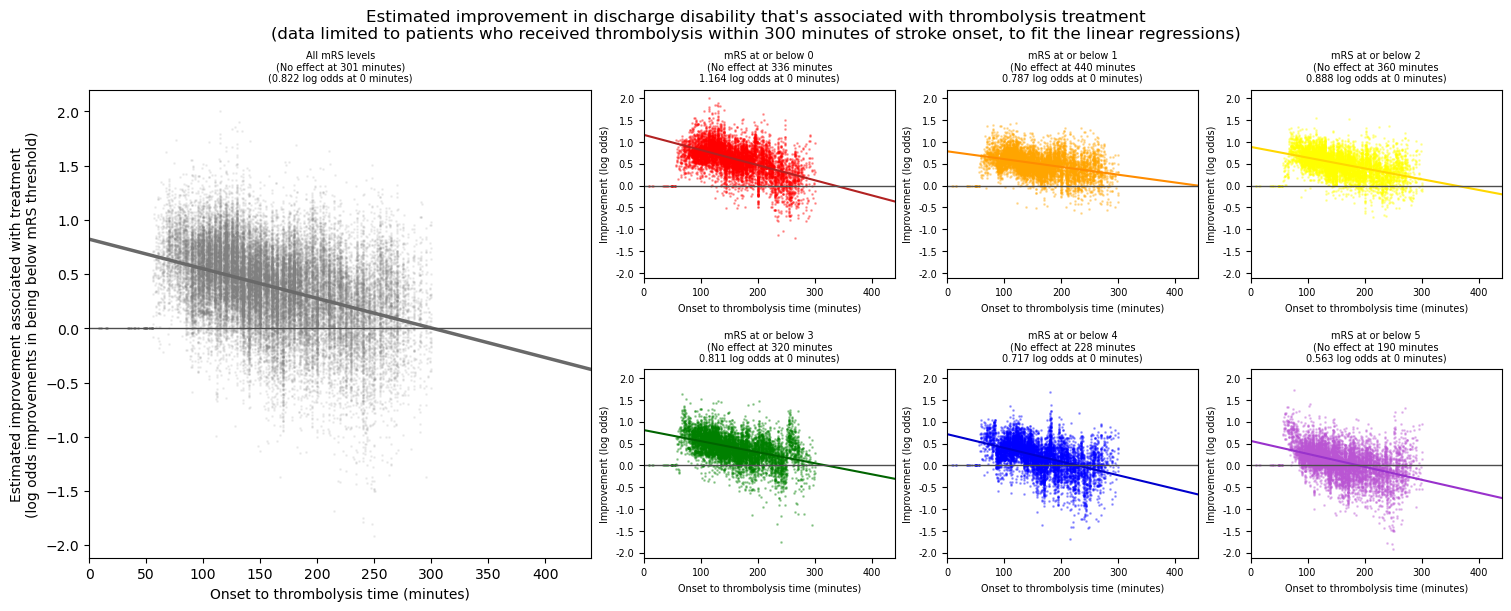

In [ ]:
max_treatment_time = 300
mask = df_test_ivt_and_no_ivt_shap["onset_to_thrombolysis_time"] <= max_treatment_time

create_mosaic_plot(df_test_ivt_and_no_ivt_shap[mask], max_treatment_time, "_nLVO_LVO")

Repeat the plot for two subpopulations: LVO vs non-LVO (using <= NIHSS 10 and >= NIHSS 11 as a surrogate to identify an LVO)

For each thrombolysed patient we calculate an estimated thrombolysis treatment effect: thrombolysis SHAP with treatment - thrombolysis SHAP if no treatment was given (by changing just thrombolysis and re-predicting thrombolysis SHAP). I've suggested we use this in the regression as well rather than using untreated thrombolysis from different patients.

We then build a XGBoost regression model to predict thrombolysis treatment effect. Then add SHAP to that, and we see what patient features improve benefit from thrombolysis, and which reduce.
We might also want to just look at characteristics of patients with a negative treatment effect, vs those with a positive treatment effect.

Already have mask_test_get_ivt & mask_train_get_ivt to use with X_train[mask_train_get_ivt] and X_test[mask_test_get_ivt]

For just nLVO patients

()

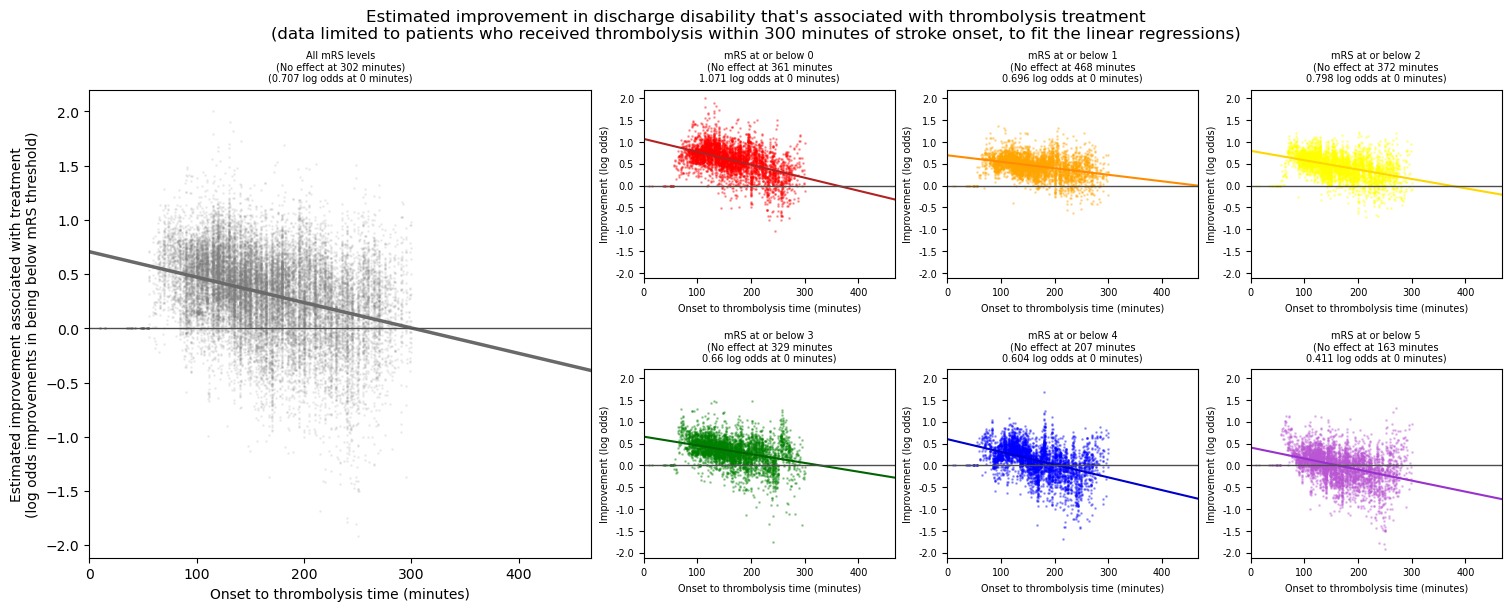

In [ ]:
nonlvo_threshold = 10
mask1 = df_test_ivt_and_no_ivt_shap["stroke_severity"] <= nonlvo_threshold
max_treatment_time = 300
mask2 = df_test_ivt_and_no_ivt_shap["onset_to_thrombolysis_time"] <= max_treatment_time

mask = mask1 * mask2

create_mosaic_plot(df_test_ivt_and_no_ivt_shap[mask], max_treatment_time, "_nLVO")

For just LVO patients

()

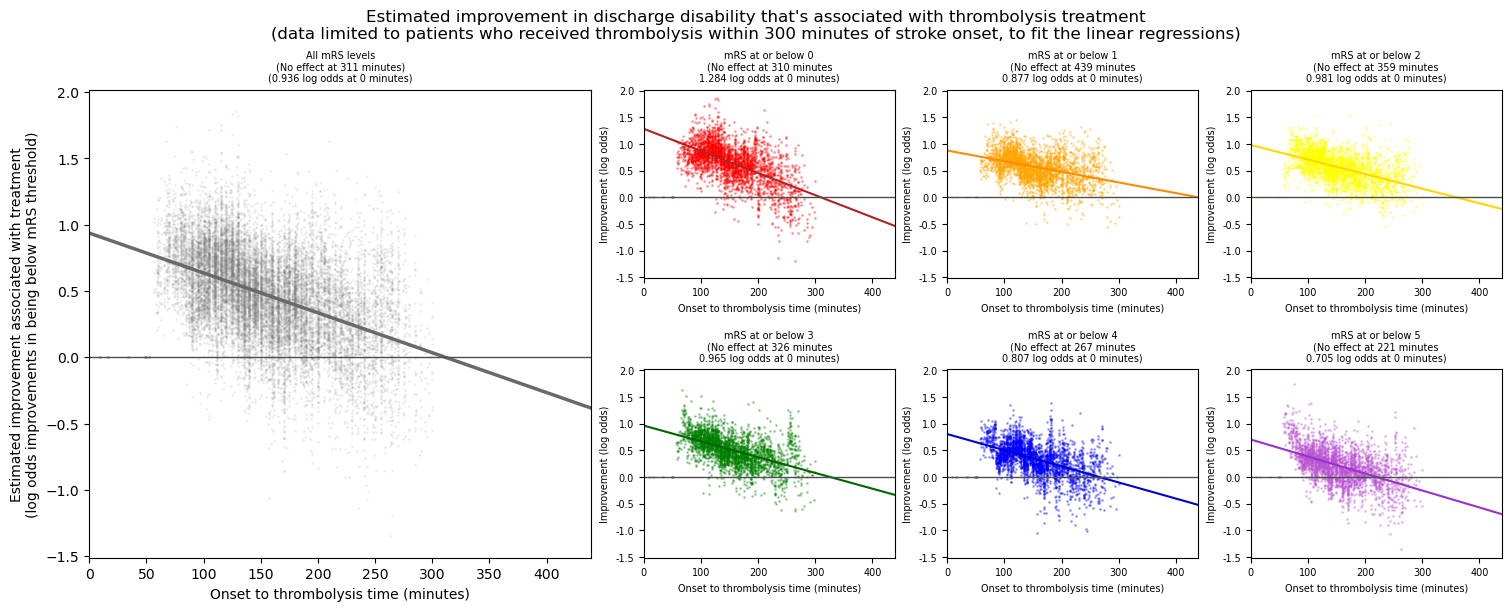

In [ ]:
mask1 = df_test_ivt_and_no_ivt_shap["stroke_severity"] > nonlvo_threshold
mask2 = df_test_ivt_and_no_ivt_shap["onset_to_thrombolysis_time"] <= max_treatment_time
mask = mask1 * mask2

create_mosaic_plot(df_test_ivt_and_no_ivt_shap[mask], max_treatment_time, "_LVO")

# NEED TO WORK OUT WHAT HAPPENONG ONWARDS, AND IF NEED FOR THE GITHUB REPOSITORY

Calculate SHAP values for the improvement due to thrombolysis for the patients in the training set (want the SHAP improvement due to IVT for the training set - will use this as the target feature in a later XGBoost model)

In [ ]:
model_threshold = []

for t in range(6):
    binary_target_feature = f'binary_{t}'
    y_train = convert_feature_to_binary(y_train_orig, t)
    y_test = convert_feature_to_binary(y_test_orig, t)

    # Model filename
    filename = os.path.join(paths.model_save_path, 
                            (paths.notebook + paths.model_text + '_' +
                             str(t) + '.p'))
    
    model_threshold.append()
    

In [ ]:
X_train_no_ivt = X_train.copy(deep=True)
X_train_no_ivt["onset_to_thrombolysis_time"] = -100
shap_values_train_no_ivt_threshold = []

# Loop through thresholds folds. Get model and get SHAP for patients not getting IVT
for t in range(6):
    model = model_threshold[t]
    
    # Set up explainer using the model and feature values from training set
    explainer = shap.TreeExplainer(model, X_train)

    # Get (and store) Shapley values along with base and feature values
    shap_values_train_extended_no_ivt = explainer(X_train_no_ivt)
    shap_values_train_no_ivt_threshold.append(shap_values_train_extended_no_ivt.values)

# Create a dataframe for the patients in the training set that got IVT (as need the onset to treatment time). 
# A row per patient. Store the features needed for the plot, and the SHAP for getting IVT at their onset to treatment time, and their SHAP if not get IVT.
df_train_ivt_and_no_ivt_shap = create_df_with_without_ivt(X_train,
                shap_values_train_threshold, shap_values_train_no_ivt_threshold)
df_train_ivt_and_no_ivt_shap.head()

 99%|===================| 133598/134677 [01:28<00:00]        

IndexError: list index out of range

In [ ]:
mask_train_get_ivt = X_train["onset_to_thrombolysis_time"] > -100
X_train_get_ivt = X_train[mask_train_get_ivt]
mask_test_get_ivt = X_test["onset_to_thrombolysis_time"] > -100
X_test_get_ivt = X_test[mask_test_get_ivt]

In [ ]:
t = 0

# get the target feature: the SHAP for improvement due to IVT 
# (wrt the mRS threshold)
mask_train_mrs = df_train_ivt_and_no_ivt_shap["mRS_threshold"] == t
y_train_shap_improvement_from_ivt  = df_train_ivt_and_no_ivt_shap["shap_ivt_improvement"][mask_train_mrs]
mask_test_mrs = df_test_ivt_and_no_ivt_shap["mRS_threshold"] == t 
y_test_shap_improvement_from_ivt = df_test_ivt_and_no_ivt_shap["shap_ivt_improvement"][mask_test_mrs]

In [ ]:
df_test_ivt_and_no_ivt_shap[mask_test_mrs]["patient_id"]

0           6
1           7
2          12
3          15
4          16
        ...  
6892    33652
6893    33656
6894    33657
6895    33666
6896    33669
Name: patient_id, Length: 6897, dtype: object

In [ ]:
r_square_threshold = []
roc_auc_ovr_threshold = []
accuracy_threshold = []
error_within_one_threshold = []
feature_importance_threshold = []
y_probs_threshold = []
y_pred_threshold = []
model_threshold = []
shap_values_extended_si_threshold = []
shap_values_si_threshold = []

# Loop through mRS thresholds
for t in range(6):

    # set string for output
    binary_target_feature = f'binary_{t}'

    # get the target feature: the SHAP for improvement due to IVT 
    # (wrt the mRS threshold)
    mask_train_mrs = df_train_ivt_and_no_ivt_shap["mRS_threshold"] == t
    y_train_shap_improvement_from_ivt = df_train_ivt_and_no_ivt_shap["shap_ivt_improvement"][mask_train_mrs]
    X_train_ivt = X_train[mask_train_mrs]
    mask_test_mrs = df_test_ivt_and_no_ivt_shap["mRS_threshold"] = t 
    y_test_shap_improvement_from_ivt = df_test_ivt_and_no_ivt_shap["shap_ivt_improvement"][mask_test_mrs]

    #check the patient ID match up between these two data sources


    # Model filename
    filename = os.path.join(paths.model_save_path, (paths.notebook + 
                            paths.model_text + '_' + str(t) + 
                            '_shapimprovment.p'))
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
    # Load models
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
            model_threshold.append(model)        
    else:
        # Define and Fit model
        model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5,
                              tree_method='gpu_hist')
        model.fit(X_train, y_train_shap_improvement_from_ivt)
        model_threshold.append(model)

        # Save using pickle
        filename = os.path.join(paths.model_save_path, (paths.notebook + 
                                paths.model_text + '_' + str(t) + 
                                '_shapimprovment.p'))
        with open(filename, 'wb') as filehandler:
            pickle.dump(model_threshold[t], filehandler)
    
    # Get target categories from model
    classes = model.classes_

    # Get and store predicted probabilities
    y_probs = model.predict_proba(X_test)
    y_probs_threshold.append(y_probs)#[:,1])

    # Get and store predicted class
    y_pred = model.predict(X_test)
    y_pred_threshold.append(y_pred)

    # Calculate ROC AUC for multiclass models, using One vs Rest
    roc_auc_ovr = roc_auc_score(y_test_shap_improvement_from_ivt, y_probs[:,1], 
                                labels = classes, 
                                multi_class = 'ovr', average = 'macro')
    roc_auc_ovr_threshold.append(roc_auc_ovr)

    # Calculate error
    y_error = y_test_shap_improvement_from_ivt - y_pred
    accuracy = np.mean(y_error==0)
    accuracy_threshold.append(accuracy)

    error_within_one = np.mean(np.abs(y_error)<=1)
    error_within_one_threshold.append(error_within_one)

    # Get and store feature importances
    feature_importance = model.feature_importances_
    feature_importance_threshold.append(feature_importance)

    # Set filename
    shap_filename = os.path.join(paths.data_save_path, (paths.notebook + 
                                paths.model_text + '_' + str(t) + 
                                '_shapimprovment_shap_values_extended.p'))
    # Check if exists
    file_exists = exists(shap_filename)

    if file_exists:
        # Load explainer
        with open(shap_filename, 'rb') as filehandler:
            shap_values_extended = pickle.load(filehandler)
            shap_values = shap_values_extended.values
            shap_values_si_threshold.append(shap_values)     
    else:
        # Get and store SHAP values
        # Set up explainer using the model and feature values from training set
        explainer = shap.TreeExplainer(model, X_train)

        # Get (and store) Shapley values along with base and feature values
        shap_values_extended = explainer(X_test)
        shap_values_extended_si_threshold.append(shap_values_extended)
        # Shap values exist for each classification in a Tree
        # We are interested in 1=give thrombolysis (not 0=not give thrombolysis)
        shap_values = shap_values_extended.values
        shap_values_si_threshold.append(shap_values)     

        explainer_filename = os.path.join(paths.model_save_path, 
                                          (paths.notebook + paths.model_text + 
                                           '_' + str(t) + 
                                           '_shapimprovment_shap_explainer.p'))

        # Save explainer using pickle
        with open(explainer_filename, 'wb') as filehandler:
            pickle.dump(explainer, filehandler)
            
        # Save shap values extendedr using pickle
        with open(shap_filename, 'wb') as filehandler:
            pickle.dump(shap_values_extended, filehandler)


100%|===================| 33559/33670 [00:23<00:00]        

In [ ]:
t=1
mask = (df_not_ivt_shap["mRS_threshold"]==t)
#

NameError: name 'df_not_ivt_shap' is not defined

In [ ]:
df_not_ivt_shap["shap_ivt"][mask]

0       -0.166807
1       -0.047152
2       -0.011488
3       -0.061943
4       -0.065017
           ...   
26768   -0.047805
26769   -0.046907
26770   -0.051523
26771   -0.095337
26772   -0.032208
Name: shap_ivt, Length: 26773, dtype: float64

In [ ]:
df_not_ivt_shap_hist = pd.DataFrame()
#            columns=["patient_id", "mRS0",_"mRS1","mRS2","mRS3","mRS4","mRS5"])

df_not_ivt_shap_hist["patient_id"] = mask_not_get_ivt.index[mask_not_get_ivt]
df_not_ivt_shap_hist

,patient_id
0,0
1,1
2,2
3,3
4,4
...,...
26768,33663
26769,33664
26770,33665
26771,33667


In [ ]:
t=0
mask = (df_not_ivt_shap["mRS_threshold"]==t) * 1


In [ ]:
df_not_ivt_shap["shap_ivt"][mask]

1   -0.023642
1   -0.047152
1   -0.052457
1   -0.002041
1    0.007191
       ...   
0   -0.166807
0   -0.166404
0   -0.126442
0   -0.050259
0   -0.062451
Name: shap_ivt, Length: 963828, dtype: float64

In [ ]:
df_not_ivt_shap_hist[f"mRS{t}"] = df_not_ivt_shap["shap_ivt"][mask]

df_not_ivt_shap_hist

In [ ]:
df_not_ivt_shap_hist = pd.DataFrame()
#            columns=["patient_id", "mRS0","mRS1","mRS2","mRS3","mRS4","mRS5"])

df_not_ivt_shap_hist["patient_id"] = mask_not_get_ivt.index[mask_not_get_ivt]
for t in range(6):
    mask = (df_not_ivt_shap["mRS_threshold"]==t)

    df_not_ivt_shap_hist[f"mRS{t}"] = df_not_ivt_shap["shap_ivt"][mask]

df_not_ivt_shap_hist

,patient_id,mRS0,mRS1,mRS2,mRS3,mRS4,mRS5
0,0,-0.099839,-0.166807,-0.166404,-0.126442,-0.050259,-0.062451
1,1,-0.023642,-0.047152,-0.052457,-0.002041,0.007191,-0.048604
2,2,-0.054853,-0.011488,0.017904,-0.018028,0.015476,0.007878
3,3,-0.073782,-0.061943,-0.071805,-0.054383,-0.029267,-0.056903
4,4,-0.141552,-0.065017,-0.052700,-0.038531,-0.025879,-0.027960
...,...,...,...,...,...,...,...
26768,33663,-0.018078,-0.047805,-0.034776,-0.043087,-0.053411,-0.047012
26769,33664,-0.029461,-0.046907,-0.041286,-0.012281,0.025063,-0.003881
26770,33665,-0.063849,-0.051523,-0.034569,0.000410,0.029581,0.010270
26771,33667,-0.084796,-0.095337,-0.091491,-0.080734,-0.051906,-0.074080


In [ ]:
df_not_ivt_shap_hist

,patient_id,mRS0,mRS1,mRS2,mRS3,mRS4,mRS5
0,0,-0.099839,-0.166807,-0.166404,-0.126442,-0.050259,-0.062451
1,1,-0.023642,-0.047152,-0.052457,-0.002041,0.007191,-0.048604
2,2,-0.054853,-0.011488,0.017904,-0.018028,0.015476,0.007878
3,3,-0.073782,-0.061943,-0.071805,-0.054383,-0.029267,-0.056903
4,4,-0.141552,-0.065017,-0.052700,-0.038531,-0.025879,-0.027960
...,...,...,...,...,...,...,...
26768,33663,-0.018078,-0.047805,-0.034776,-0.043087,-0.053411,-0.047012
26769,33664,-0.029461,-0.046907,-0.041286,-0.012281,0.025063,-0.003881
26770,33665,-0.063849,-0.051523,-0.034569,0.000410,0.029581,0.010270
26771,33667,-0.084796,-0.095337,-0.091491,-0.080734,-0.051906,-0.074080


Text(0.5, 1.0, 'Frequency of SHAP values for each mRS threshold')

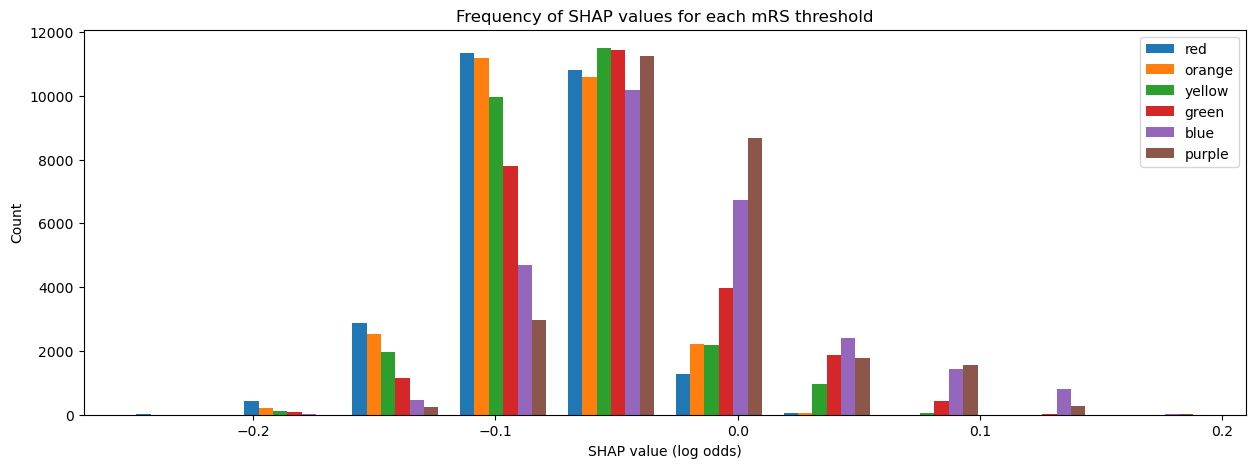

In [ ]:
#fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2)
fig, ax = plt.subplots(figsize=(15, 5))
colors = ["red","orange","yellow","green","blue","purple"]
label = ["mRS0","mRS1","mRS2","mRS3","mRS4","mRS5"]
ax.hist(np.array(df_not_ivt_shap_hist[label]), 10, histtype='bar', label=label, color=colors)
ax.legend(prop={'size': 10})
ax.set_xlabel("SHAP value (log odds)")
ax.set_ylabel("Count")
ax.set_title('Frequency of SHAP values for each mRS threshold')

In [ ]:
np.array(df_not_ivt_shap_hist[label]).shape

(26773, 6)

In [ ]:
df_not_ivt_shap["shap_ivt"].groupby(["mRS_threshold"])

KeyError: 'mRS_threshold'

In [ ]:
model = LinearRegression(df_ivt_shap["shap_ivt"],df_ivt_shap["onset_to_thrombolysis_time"])

Duration to run notebook

In [ ]:
str(datetime.timedelta(seconds=(time.time()-start_time)))